In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from heat_1d_2d import heat_1d_nn, heat_2d_nn
np.random.seed(238)
torch.manual_seed(301)

/tmp/ipykernel_5425/780637763.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_colloc = torch.tensor(xs, dtype=torch.float32)
/tmp/ipykernel_5425/780637763.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_colloc = torch.tensor(ts, dtype=torch.float32)


Epoch 0, Loss: 89.793434
Epoch 50, Loss: 66.762016
Epoch 100, Loss: 58.945694
Epoch 150, Loss: 54.576824
Epoch 200, Loss: 51.018158
Epoch 250, Loss: 48.322994
Epoch 300, Loss: 46.090794
Epoch 350, Loss: 44.441681
Epoch 400, Loss: 42.823124
Epoch 450, Loss: 41.712563
Epoch 500, Loss: 41.891727
Epoch 550, Loss: 39.844875
Epoch 600, Loss: 39.157948
Epoch 650, Loss: 38.585552
Epoch 700, Loss: 39.439587
Epoch 749, Loss: 41.401573
LBFGS Epoch 1, Loss: 32.688717
LBFGS Epoch 2, Loss: nan
LBFGS Epoch 3, Loss: nan
LBFGS Epoch 4, Loss: nan
LBFGS Epoch 5, Loss: nan
LBFGS Epoch 6, Loss: nan
LBFGS Epoch 7, Loss: nan
LBFGS Epoch 8, Loss: nan
LBFGS Epoch 9, Loss: nan
LBFGS Epoch 10, Loss: nan


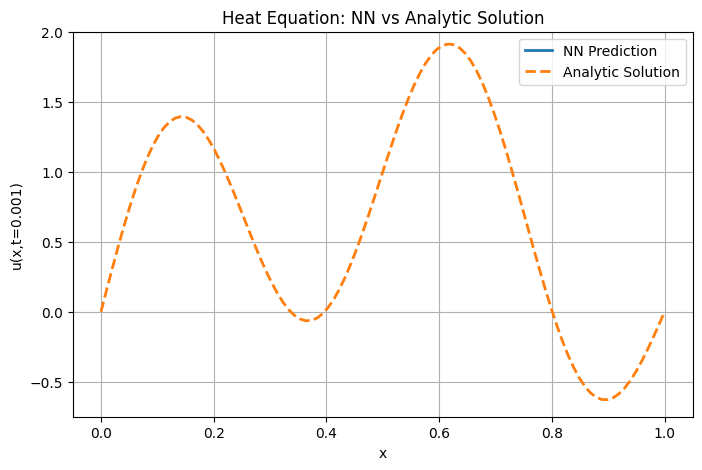

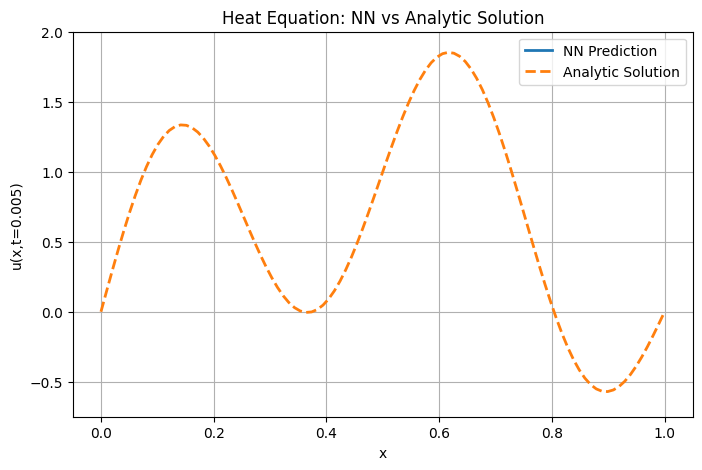

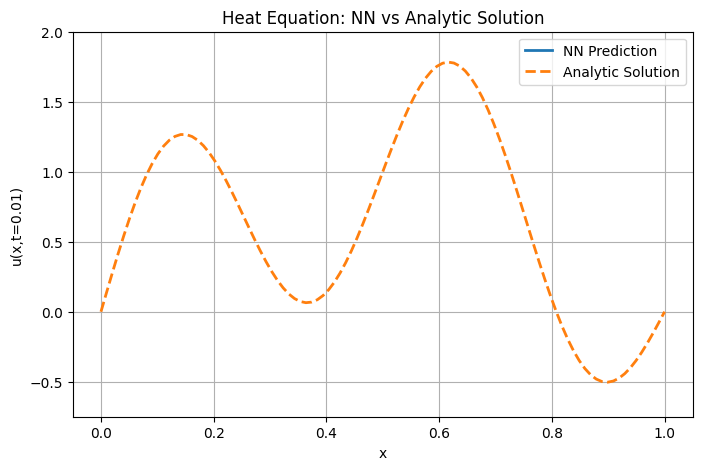

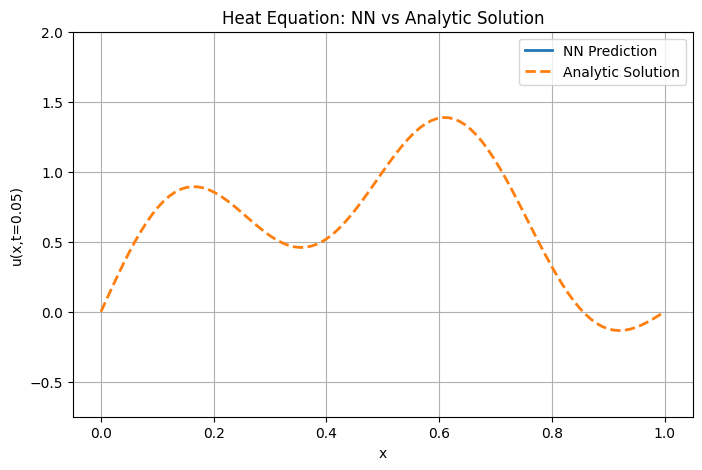

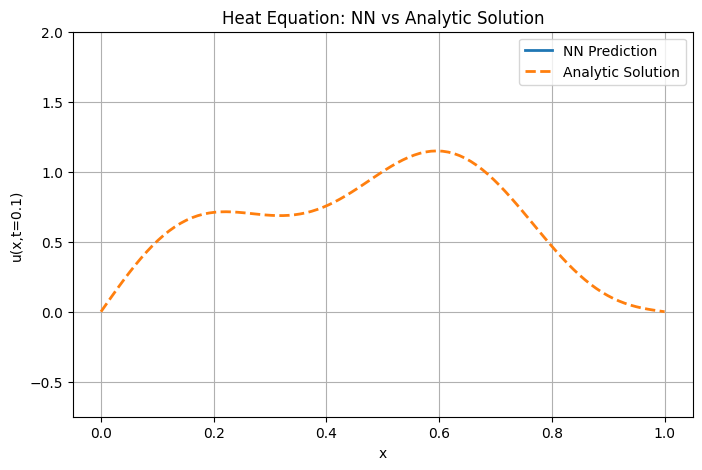

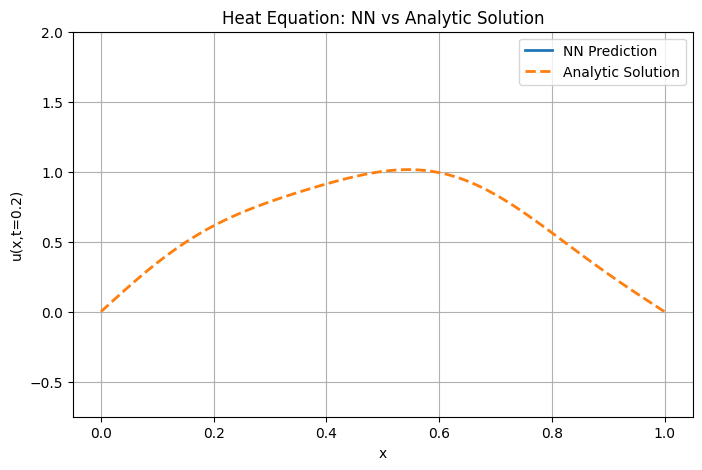

In [ ]:
layers = [32, 64, 128, 128, 1]
#in this example: the output layer uses identity as activation func and all the hidden layers use tanh
activations = [torch.tanh]*(len(layers)-1) + [None]
pde_nn = heat_1d_nn(layers, activations)


N_colloc = 100
x = np.linspace(0, 1, N_colloc)
t = np.linspace(0, 0.2, N_colloc)

xs, ts = np.meshgrid(x, t)

xs = torch.tensor(xs, dtype=torch.float32).view(-1, 1)
ts = torch.tensor(ts, dtype=torch.float32).view(-1, 1)

x_colloc = torch.tensor(xs, dtype=torch.float32)
t_colloc = torch.tensor(ts, dtype=torch.float32)

"""
N = 1000
x_colloc= torch.rand(N,1)
t_colloc = 0.2*torch.rand(N,1)
"""
# gives relatively good results (compared to other parameters, still bad though)
pde_nn.train(x_colloc, t_colloc, lr=1e-2, weight_decay=0.0, epochs = 750, print_epochs=50)
# LBFGS needs approximately 100 epochs, 30 iterations for kappa = 1
# if kappa = 0.1, better choose more iterations, less epochs
pde_nn.train_lbfgs(x_colloc, t_colloc, lr=1, epochs=10, max_iter=100)

for t in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    x_test = torch.linspace(0,1,100).view(-1,1)
    t_test = torch.tensor([[t]]*100)  # t=0.5
    u_pred = pde_nn.trial_solution(x_test, t_test).detach().numpy()


    #compare results with analytic solution

    x_np = x_test.numpy().flatten()  # convert to 1D array for plotting
    t_val = t
    u_analytic_values  = np.array([pde_nn.u_analytic(x,t) for (x,t) in zip(x_np, t_val)]) 

    # Plot the results
    plt.figure(figsize=(8,5))
    plt.plot(x_np, u_pred, label='NN Prediction', linewidth=2)
    plt.plot(x_np, u_analytic_values, '--', label='Analytic Solution', linewidth=2)
    plt.xlabel('x')
    plt.ylabel(f'u(x,t={t})')
    plt.ylim(-0.75, 2.0)
    plt.title('Heat Equation: NN vs Analytic Solution')
    plt.legend()
    plt.grid(True)
    plt.show()

In [6]:
def lhs_samples(n_samples, bounds):
    """
    Generate Latin Hypercube Samples (LHS) and scale them to given bounds.

    ```
    Args:
        n_samples (int): Number of samples to generate.
        bounds (list of tuples): [(min1, max1), (min2, max2), ...] for each dimension.
        device (str): 'cpu' or 'cuda'

    Returns:
        list of lists: Each inner list corresponds to one dimension and contains n_samples values.
    """
    n_dimensions = len(bounds)

    # Step 1: Create intervals and random points in each interval
    intervals = torch.linspace(0, 1, steps=n_samples + 1)
    samples = torch.rand(n_samples, n_dimensions)
    samples = intervals[:-1].unsqueeze(1) + samples * (intervals[1:] - intervals[:-1]).unsqueeze(1)

    # Step 2: Shuffle each dimension independently
    for dim in range(n_dimensions):
        indices = torch.randperm(n_samples)
        samples[:, dim] = samples[indices, dim]

    # Step 3: Scale to bounds
    for i, (low, high) in enumerate(bounds):
        samples[:, i] = low + (high - low) * samples[:, i]

    # Step 4: Convert to list of lists
    return [samples[:, i].clone().view(-1,1) for i in range(n_dimensions)]
    

# Example usage

bounds = [(0, 10), (-5, 5), (100, 200)]
n_samples = 10
samples_list = lhs_samples(n_samples, bounds)
print(samples_list)  # List of 3 lists, each with 10 samples


[tensor([[4.1762],
        [3.6922],
        [8.1355],
        [5.2480],
        [2.8165],
        [0.3437],
        [1.9288],
        [6.2782],
        [7.3411],
        [9.5289]]), tensor([[ 3.7529],
        [-2.8347],
        [ 2.7018],
        [ 0.4541],
        [-0.8896],
        [-3.3455],
        [-1.4962],
        [ 4.3415],
        [-4.9237],
        [ 1.3090]]), tensor([[127.1978],
        [135.8932],
        [154.9484],
        [161.7480],
        [174.2310],
        [198.3754],
        [110.8522],
        [141.1792],
        [185.1040],
        [109.5584]])]


In [13]:
"""
2D Heat equation
"""

layers = [32, 64, 128, 128, 1]
activations = [torch.tanh]*(len(layers)-1) + [None]

bounds = [(0,1), (0,1), (0, 0.2)]
n_samples = 10000
x_colloc, y_colloc, t_colloc = lhs_samples(n_samples, bounds)
""""
N_colloc = 20

x = np.linspace(0, 1, N_colloc)
y = np.linspace(0, 1, N_colloc)
t = np.linspace(0, 1, N_colloc)

xs, ys, ts = np.meshgrid(x, y, t)

xs = torch.tensor(xs, dtype=torch.float32).view(-1, 1)
ys = torch.tensor(ys, dtype=torch.float32).view(-1, 1)
ts = torch.tensor(ts, dtype=torch.float32).view(-1, 1)

x_colloc = torch.tensor(xs, dtype=torch.float32).view(-1,1)
y_colloc = torch.tensor(ys, dtype=torch.float32).view(-1,1)
t_colloc = torch.tensor(ts, dtype=torch.float32).view(-1,1)
"""
pde_nn = heat_2d_nn(layers, activations)

pde_nn.train(x_colloc, y_colloc, t_colloc, lr=1e-2, weight_decay=0, epochs = 1_000, print_epochs=50)
#proper result for epochs =5000
pde_nn.train_lbfgs(x_colloc, t_colloc, y_colloc, lr=1, epochs=20, max_iter=30)

x_test = torch.linspace(0,1,100).view(-1,1)
y_test = torch.linspace(0,1,100).view(-1,1)
t_test = torch.tensor([[0.001]]*100)  # t=0.001
u_pred = pde_nn.trial_solution(x_test, y_test, t_test).detach().numpy()


#compare results with analytic solution

x_np = x_test.numpy().flatten()  # convert to 1D array for plotting
y_np = y_test.numpy().flatten()
t_val = 0.5
u_analytic = np.sin(np.pi * x_np) * np.sin(np.pi * y_np) * np.exp(
    -2 * np.pi**2 * t_val) + np.sin(2 * np.pi * x_np) * np.sin(4 * np.pi * x_np
    ) * np.exp(-20 * np.pi**2 * t_val)

Epoch 0, Loss: 8063.458496
Epoch 50, Loss: 7573.354980
Epoch 100, Loss: 7154.819336
Epoch 150, Loss: 5084.132812
Epoch 200, Loss: 3237.872559
Epoch 250, Loss: 2006.375610
Epoch 300, Loss: 1671.787842
Epoch 350, Loss: 1404.756592
Epoch 400, Loss: 1262.337646
Epoch 450, Loss: 1145.367798
Epoch 500, Loss: 1040.201660
Epoch 550, Loss: 962.478088
Epoch 600, Loss: 902.141479
Epoch 650, Loss: 856.840698
Epoch 700, Loss: 796.129761
Epoch 750, Loss: 759.101807
Epoch 800, Loss: 712.073730
Epoch 850, Loss: 692.851379
Epoch 900, Loss: 645.076172
Epoch 950, Loss: 608.568359
Epoch 999, Loss: 573.956604
LBFGS Epoch 1, Loss: 251.543472
LBFGS Epoch 2, Loss: 203.036179
LBFGS Epoch 3, Loss: 181.220322
LBFGS Epoch 4, Loss: 167.050430
LBFGS Epoch 5, Loss: 155.407379
LBFGS Epoch 6, Loss: 147.633484
LBFGS Epoch 7, Loss: 140.821243
LBFGS Epoch 8, Loss: 133.291580
LBFGS Epoch 9, Loss: 127.153473
LBFGS Epoch 10, Loss: 121.255424
LBFGS Epoch 11, Loss: 117.041725
LBFGS Epoch 12, Loss: 112.765785
LBFGS Epoch 13, L

In [11]:
"""
2D Heat equation
"""

layers = [50, 50, 50, 50, 50, 50, 1]
activations = [torch.tanh]*(len(layers)-1) + [None]

bounds = [(0,1), (0,1), (0, 0.2)]
n_samples = 10000
x_colloc, y_colloc, t_colloc = lhs_samples(n_samples, bounds)
""""
N_colloc = 20

x = np.linspace(0, 1, N_colloc)
y = np.linspace(0, 1, N_colloc)
t = np.linspace(0, 1, N_colloc)

xs, ys, ts = np.meshgrid(x, y, t)

xs = torch.tensor(xs, dtype=torch.float32).view(-1, 1)
ys = torch.tensor(ys, dtype=torch.float32).view(-1, 1)
ts = torch.tensor(ts, dtype=torch.float32).view(-1, 1)

x_colloc = torch.tensor(xs, dtype=torch.float32).view(-1,1)
y_colloc = torch.tensor(ys, dtype=torch.float32).view(-1,1)
t_colloc = torch.tensor(ts, dtype=torch.float32).view(-1,1)
"""
pde_nn = heat_2d_nn(layers, activations)

#pde_nn.train(x_colloc, y_colloc, t_colloc, lr=1e-2, weight_decay=0, epochs = 1_000, print_epochs=50)
#proper result for epochs =5000
pde_nn.train_lbfgs(x_colloc, t_colloc, y_colloc, lr=1, epochs=10, max_iter=30000)

x_test = torch.linspace(0,1,100).view(-1,1)
y_test = torch.linspace(0,1,100).view(-1,1)
t_test = torch.tensor([[0.001]]*100)  # t=0.001
u_pred = pde_nn.trial_solution(x_test, y_test, t_test).detach().numpy()


#compare results with analytic solution

x_np = x_test.numpy().flatten()  # convert to 1D array for plotting
y_np = y_test.numpy().flatten()
t_val = 0.5
u_analytic = np.sin(np.pi * x_np) * np.sin(np.pi * y_np) * np.exp(
    -2 * np.pi**2 * t_val) + np.sin(2 * np.pi * x_np) * np.sin(4 * np.pi * x_np
    ) * np.exp(-20 * np.pi**2 * t_val)

KeyboardInterrupt: 